# Cartesian sampling along a 1D variable density

In this notebook, we perform pseudo-random variable density sampling along the phase encoding direction. 
A handcrafted density is designed and samples are then drawn by virtually inverting its cumulative density function. Then these samples define the selected phase encoding lines retained in the sampling mask. Low frequencies are more sampled than higher frequencies. 
* Author: Philippe Ciuciu (philippe.ciuciu@cea.fr)
* Date: 04/03/2019
* Target: [ISBI'19 tutorial](https://biomedicalimaging.org/2019/tutorials/) on **Recent  advances in acquisition and reconstruction for Compressed Sensing MRI**
- **Revision**: 01/05/2021 for ATSI MSc hands-on session at Paris-Saclay University.

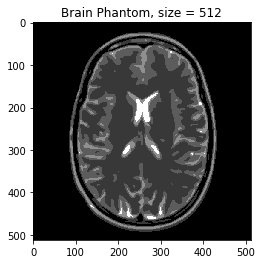

In [1]:
#DISPLAY BRAIN PHANTOM
%matplotlib inline

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys

from skimage import data, io, filters
#get current working dir
cwd = os.getcwd()
#cwd= "/"
dirimg_2d = op.join(cwd, "..", "data")
img_size = 512   #256
FOV = 0.2 #field of view in meters
pixelSize = FOV/img_size

#load data file corresponding to the target resolution
filename = "BrainPhantom" + str(img_size) + ".png"
mri_filename = op.join(dirimg_2d, filename)
mri_img = io.imread(mri_filename, as_gray=True)
plt.figure()
plt.title("Brain Phantom, size = "+ str(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

64
[179 255 300 316 255 255 207 257 365 277 236 167 255 255 255 261 258 253
 170 170 305 255 294 256 150 255 285 258 248 262 241 255 163 255 246  51
 215 255 253 255 251 241 198 318 257 337 359 256 259 255 255  15 255 248
 255 255 254 255 255 255 245 246 210 263]


<Figure size 432x288 with 0 Axes>

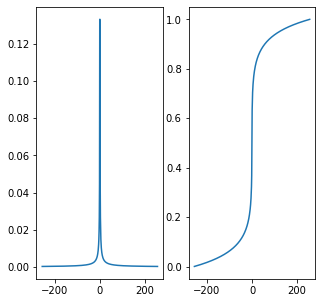

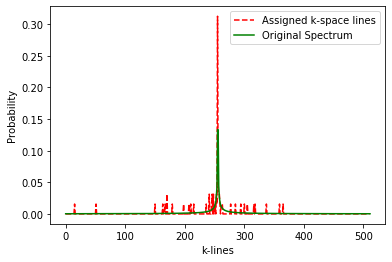

[ 15  51 150 163 167 170 179 198 207 210 215 236 241 245 246 248 251 253
 254 255 256 257 258 259 261 262 263 277 285 294 300 305 316 318 337 359
 365]
37


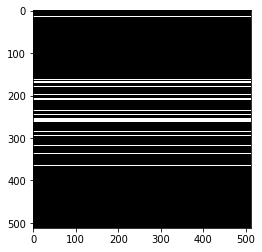

In [2]:
import numpy as np
import sys
import numpy.random as ra

eps = sys.float_info.epsilon
#img_size = 512
# generate Cartesian lines in a straightforward manner
#a = np.linspace(0,img_size,img_size)
a = (np.linspace(0,img_size,img_size+1))/img_size -0.5    # work in normalized frequency
 

c = np.ones((1, img_size), dtype="float64")
kspace_mask = np.tile(c, (img_size, 1))
#kspace_lines = np.linspace(-1/2., 1/2.,img_size)
kspace_lines = np.linspace(-1/2., 1/2.,img_size)*img_size
# define the taret sampling density (ie non-iniform over k-space lines)
decay = 1.
# Define the sampling density
p_decay = np.power(np.abs(kspace_lines),-decay)
p_decay = p_decay/np.sum(p_decay)
# generate its CDF
cdf_pdecay = np.cumsum(p_decay)


pmax = p_decay.max()
pmin = p_decay.min()

# Plot the density and its cumulative distribution function (CDF) p_decay
plt.figure()
fig, axs = plt.subplots(1, 2, figsize= (5,5) )
axs[0].plot(kspace_lines, p_decay)
axs[1].plot(kspace_lines, cdf_pdecay)

# Perform pseudo-random sampling: technique used:
# draw uniform variables and invert the CDF to get back to p_decay-distributed sampled
nb_samples = (int)(img_size/8)
print(nb_samples)
samples = ra.uniform(0, 1, nb_samples)
gen_klines = [int(kspace_lines[np.argwhere(cdf_pdecay == min(cdf_pdecay[(cdf_pdecay - r) > 0]))]) for r in samples]

# shift the samples lines by half of the k-space (ie image size as we're in Cartesian ref)
gen_klinesb = ((np.array(gen_klines) - 1) / 1).astype(int) + (int)(img_size/2)
#gen_klinesb = ((np.array(gen_klines) - 1) / 1).astype(int)
print(gen_klinesb)   # unsorted samples
times = np.arange(1, img_size, 1)
lc = np.bincount(gen_klinesb, minlength=len(times))

# check that histogram of sample values fits the prescribed density p_decay
plt.figure()
plot1, = plt.plot(lc/float(sum(lc)), 'r--', label='Assigned k-space lines')
plot2, = plt.plot(p_decay,'g',label='Original Spectrum')
plt.xlabel('k-lines')
plt.ylabel('Probability')
plt.legend(handles=[plot1,plot2])
plt.show()


#print(p_decay.min())
sampled_klines = np.array(np.unique(gen_klinesb))
print(sampled_klines)

nblines = np.size(sampled_klines)
print(nblines)
threshold = 2. * p_decay.min()  # sys.float_info.epsilon \simeq 2e-16
kspace_mask = np.zeros((img_size,img_size), dtype="float64")
kspace_mask[sampled_klines,:] = np.ones((nblines,img_size) , dtype="float64")

plt.figure()
plt.imshow(kspace_mask, cmap='gray')
plt.show()


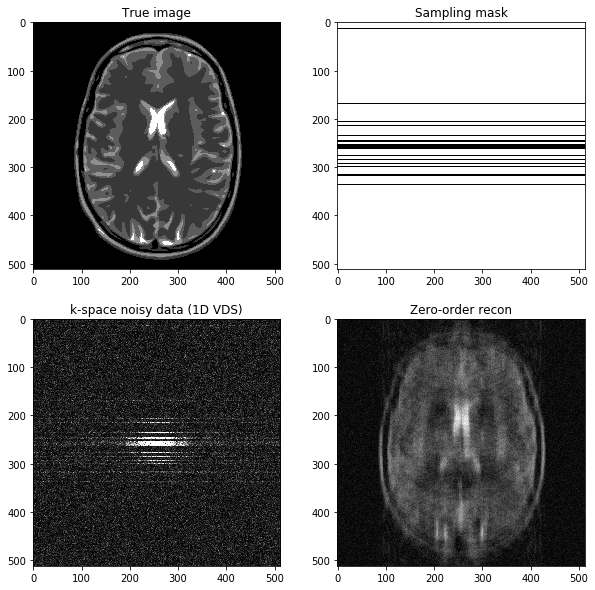

In [3]:
#import numpy.fft as fft
norm = "ortho"
#norm = None
def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)


# Generate the kspace data: first Fourier transform the image
kspace_data = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Mask data to perform subsampling
kspace_data *= kspace_mask 

#noisy k-space data using Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(10, 10) )
axs[0,0].imshow(mri_img, cmap='gray')
axs[0,0].set_title("True image")
axs[0,1].imshow(kspace_mask, cmap='gray_r')
axs[0,1].set_title("Sampling mask")
axs[1,0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.005*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1,0].set_title("k-space noisy data (1D VDS)")
axs[1,1].imshow(np.abs(image_rec0), cmap='gray')
axs[1,1].set_title("Zero-order recon")
plt.show()
